<a href="https://colab.research.google.com/github/aestery/HPPL_Project/blob/main/HPPL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In [ ]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.35
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time

from numba import jit, prange


class MyProfiler():

    def __init__(self, file_name: str):
        self.file_name = file_name
        self.sequential_frames = []
        self.parallel_frames = []

        self.initialization = [[],[]]   #cupy vs python
        self.conductivity = [[],[]]     #cupy vs python
        self.tfield_cpu = []            #jit
        self.tfield_gpu = []            #cupy
        self.tfield_seq = []            #python

        self.overall = []

    def write_file(self):
        with open(f"{self.file_name}.log", "w"):
            pass

    def visualize(self):
        initialization_p = np.array(self.initialization[0])
        initialization_s = np.array(self.initialization[1])
        conductivity_p = np.asarray(self.conductivity[0])
        conductivity_s = np.asarray(self.conductivity[1])
        tfieldc = np.array(self.tfield_cpu)
        tfieldg =  np.array(self.tfield_gpu)
        tfields =  np.array(self.tfield_seq)

        plt.bar(["parallel", "sequential"], [initialization_p[0], initialization_s[0]], color=["blue", "orange"])
        plt.ylabel("Execution Time (seconds)")
        plt.title("Comparison of initialization time")
        plt.show()
        print(initialization_p, initialization_s, sep='\n')
        plt.plot(conductivity_p, label='conductivity_p')
        plt.plot(conductivity_s, label='conductivity_s')
        plt.xlabel("steps")
        plt.ylabel("time, s")
        plt.legend()
        plt.show()
        plt.plot(tfieldc, label="update_temperature_field_cpu")
        plt.plot(tfieldg, label="update_temperature_field_gpu")
        plt.plot(tfields, label="update_temperature_field_seq")
        plt.xlabel("steps")
        plt.ylabel("time, s")
        plt.legend()
        plt.show()
#        plt.bar(["parallel", "sequential"], [self.overall[0], self.overall[1]] color=["blue", "orange"])
#        plt.ylabel("Execution Time (seconds)")
#        plt.title("Comparison of overall time")
        print(self.overall)

MY_PROFILER = MyProfiler("test")

def measure_time(type: str, proc: int):
    def Inner(function):
        def wrapper(*args, **kwargs):
            start_time = time.perf_counter()
            result = function(*args, **kwargs)
            end_time = time.perf_counter()
            time_consumed = end_time - start_time
            if type == "init":
                MY_PROFILER.initialization[proc].append(time_consumed)
            elif type == "conduct":
                MY_PROFILER.conductivity[proc].append(time_consumed)
            elif type == "tfieldc":
                MY_PROFILER.tfield_cpu.append(time_consumed)
            elif type == "tfieldg":
                MY_PROFILER.tfield_gpu.append(time_consumed)
            elif type == "tfields":
                MY_PROFILER.tfield_seq.append(time_consumed)
            elif type == "overall":
                MY_PROFILER.overall.append(time_consumed)
            return result
        return wrapper
    return Inner

In [ ]:
GRID_SIZE = 100
TIME_STEPS = 50
DELTA_T = 0.01
DELTA_X = 0.1
USE_GPU = True

@measure_time(type="init",proc=0)
def initialize_temperature_field(grid_size):
    """Initializes the temperature field with zeros or predefined values."""
    start_time = time.time()
    if USE_GPU:
        temperature_field = cp.zeros((grid_size, grid_size, grid_size), dtype=cp.float32)
        temperature_field[grid_size//2, grid_size//2, grid_size//2] = 1000  # Heat source
    else:
        temperature_field = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
        temperature_field[grid_size//2, grid_size//2, grid_size//2] = 1000  # Heat source
    end_time = time.time()
    MY_PROFILER.initialization[0].append(end_time - start_time)
    return temperature_field

@measure_time(type="conduct",proc=0)
def temperature_dependent_conductivity(temperature):
    """Computes thermal conductivity as a function of temperature."""
    THERMAL_CONDUCTIVITY_BASE = 100.0
    ALPHA = 0.005
    if USE_GPU:
        return THERMAL_CONDUCTIVITY_BASE * (1 + ALPHA * temperature)
    else:
        return THERMAL_CONDUCTIVITY_BASE * (1 + ALPHA * temperature)

@measure_time(type="tfieldc",proc=0)
@jit(nopython=True, parallel=True)
def update_temperature_field_cpu(temperature_field, conductivity_field, delta_t, delta_x):
    """Updates the temperature field using finite difference equations on CPU."""
    grid_size = temperature_field.shape[0]
    new_temperature_field = np.copy(temperature_field)
    for i in prange(1, grid_size - 1):
        for j in prange(1, grid_size - 1):
            for k in prange(1, grid_size - 1):
                k_x = conductivity_field[i, j, k]
                new_temperature_field[i, j, k] = temperature_field[i, j, k] + delta_t * (
                    (k_x / delta_x**2) * (
                        temperature_field[i+1, j, k] - 2*temperature_field[i, j, k] + temperature_field[i-1, j, k] +
                        temperature_field[i, j+1, k] - 2*temperature_field[i, j, k] + temperature_field[i, j-1, k] +
                        temperature_field[i, j, k+1] - 2*temperature_field[i, j, k] + temperature_field[i, j, k-1]
                    )
                )
    return new_temperature_field

@measure_time(type="tfieldg",proc=0)
def update_temperature_field_gpu(temperature_field, conductivity_field, delta_t, delta_x):
    """Updates the temperature field using finite difference equations on GPU."""
    grid_size = temperature_field.shape[0]
    new_temperature_field = cp.copy(temperature_field)
    # Apply finite difference update rules using CuPy's element-wise operations
    k_x = conductivity_field
    new_temperature_field[1:-1, 1:-1, 1:-1] = temperature_field[1:-1, 1:-1, 1:-1] + delta_t * (
        (k_x[1:-1, 1:-1, 1:-1] / delta_x**2) * (
            temperature_field[2:, 1:-1, 1:-1] - 2 * temperature_field[1:-1, 1:-1, 1:-1] + temperature_field[:-2, 1:-1, 1:-1] +
            temperature_field[1:-1, 2:, 1:-1] - 2 * temperature_field[1:-1, 1:-1, 1:-1] + temperature_field[1:-1, :-2, 1:-1] +
            temperature_field[1:-1, 1:-1, 2:] - 2 * temperature_field[1:-1, 1:-1, 1:-1] + temperature_field[1:-1, 1:-1, :-2]
        )
    )
    return new_temperature_field

def compute_conductivity_field(temperature_field):
    """Computes the thermal conductivity field based on the temperature field."""
    return temperature_dependent_conductivity(temperature_field)

def apply_boundary_conditions(temperature_field):
    """Applies fixed boundary conditions to the temperature field."""
    if USE_GPU:
        temperature_field[0, :, :] = 0
        temperature_field[-1, :, :] = 0
        temperature_field[:, 0, :] = 0
        temperature_field[:, -1, :] = 0
        temperature_field[:, :, 0] = 0
        temperature_field[:, :, -1] = 0
    else:
        temperature_field[0, :, :] = 0
        temperature_field[-1, :, :] = 0
        temperature_field[:, 0, :] = 0
        temperature_field[:, -1, :] = 0
        temperature_field[:, :, 0] = 0
        temperature_field[:, :, -1] = 0
    return temperature_field

def visualize_temperature_field(temperature_field, time_step):
    """Visualizes the temperature field at a specific time step."""

    mid_slice = cp.asnumpy(temperature_field)[temperature_field.shape[0] // 2, :, :] if USE_GPU else temperature_field[temperature_field.shape[0] // 2, :, :]
    MY_PROFILER.parallel_frames.append(mid_slice)
#    plt.imshow(mid_slice, cmap="hot", interpolation="nearest")
#    plt.colorbar()
#    plt.title(f"Temperature Field at Time Step {time_step}")
#    plt.show()

def measure_computation_time(function, *args):
    """Measures and prints the computation time of a given function."""
    start_time = time.time()
    result = function(*args)
    end_time = time.time()
    print(f"Execution time: {end_time - start_time:.2f} seconds")
    return result

@measure_time(type="overall",proc=0)
def simulate_heat_transfer(grid_size, time_steps, delta_t, delta_x):
    """Runs the simulation."""
    temperature_field = initialize_temperature_field(grid_size)
    for t in range(time_steps):
        conductivity_field = compute_conductivity_field(temperature_field)
        if USE_GPU:
            temperature_field = update_temperature_field_gpu(temperature_field, conductivity_field, delta_t, delta_x)
        else:
            temperature_field = update_temperature_field_cpu(temperature_field, conductivity_field, delta_t, delta_x)
        temperature_field = apply_boundary_conditions(temperature_field)
        #if t % 10 == 0:
        visualize_temperature_field(temperature_field, t)
    return temperature_field

if __name__ == "__main__":
    final_temperature_field = measure_computation_time(simulate_heat_transfer, GRID_SIZE, TIME_STEPS, DELTA_T, DELTA_X)


Execution time: 0.16 seconds


In [ ]:
GRID_SIZE = 50
TIME_STEPS = 10
DELTA_T = 0.01
DELTA_X = 0.1

@measure_time(type="init",proc=1)
def initialize_temperature_field(grid_size):
    """Initializes the temperature field with zeros."""
    temperature_field = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    temperature_field[grid_size//2, grid_size//2, grid_size//2] = 1000  # Heat source
    return temperature_field

@measure_time(type="conduct",proc=1)
def temperature_dependent_conductivity(temperature):
    """Computes thermal conductivity as a linear function of temperature."""
    THERMAL_CONDUCTIVITY_BASE = 10.0
    ALPHA = 0.005
    return THERMAL_CONDUCTIVITY_BASE * (1 + ALPHA * temperature)

@measure_time(type="tfields",proc=1)
def update_temperature_field(temperature_field, conductivity_field, delta_t, delta_x):
    """Updates the temperature field using finite difference equations."""
    grid_size = temperature_field.shape[0]
    new_temperature_field = np.copy(temperature_field)
    for i in range(1, grid_size - 1):
        for j in range(1, grid_size - 1):
            for k in range(1, grid_size - 1):
                k_x = conductivity_field[i, j, k]
                new_temperature_field[i, j, k] = temperature_field[i, j, k] + delta_t * (
                    (k_x / delta_x**2) * (
                        temperature_field[i+1, j, k] - 2*temperature_field[i, j, k] + temperature_field[i-1, j, k] +
                        temperature_field[i, j+1, k] - 2*temperature_field[i, j, k] + temperature_field[i, j-1, k] +
                        temperature_field[i, j, k+1] - 2*temperature_field[i, j, k] + temperature_field[i, j, k-1]
                    )
                )
    return new_temperature_field

def compute_conductivity_field(temperature_field):
    """Computes the thermal conductivity field based on the temperature field."""
    conductivity_field = temperature_dependent_conductivity(temperature_field)
    return conductivity_field

def apply_boundary_conditions(temperature_field):
    """Applies fixed boundary conditions to the temperature field."""
    temperature_field[0, :, :] = 0   # Top boundary
    temperature_field[-1, :, :] = 0  # Bottom boundary
    temperature_field[:, 0, :] = 0   # Left boundary
    temperature_field[:, -1, :] = 0  # Right boundary
    temperature_field[:, :, 0] = 0   # Front boundary
    temperature_field[:, :, -1] = 0  # Back boundary
    return temperature_field

def visualize_temperature_field(temperature_field, time_step):
    """Visualizes the temperature field at a specific time step."""
    mid_slice = temperature_field[temperature_field.shape[0] // 2, :, :]
    MY_PROFILER.sequential_frames.append(mid_slice)
#    plt.imshow(mid_slice, cmap="hot", interpolation="nearest")
#    plt.colorbar()
#    plt.title(f"Temperature Field at Time Step {time_step}")
#    plt.show()

def measure_computation_time(function, *args):
    """Measures and prints the computation time of a given function."""
    start_time = time.time()
    result = function(*args)
    end_time = time.time()
    print(f"Execution time: {end_time - start_time:.2f} seconds")
    return result

@measure_time(type="overall",proc=1)
def simulate_heat_transfer(grid_size, time_steps, delta_t, delta_x):
    """Runs the simulation."""
    temperature_field = initialize_temperature_field(grid_size)
    for t in range(time_steps):
        conductivity_field = compute_conductivity_field(temperature_field)
        temperature_field = update_temperature_field(temperature_field, conductivity_field, delta_t, delta_x)
        temperature_field = apply_boundary_conditions(temperature_field)
        #if t % 10 == 0:  # Visualize every 10 steps
        visualize_temperature_field(temperature_field, t)
    return temperature_field

if __name__ == "__main__":
    start = time.time()
    final_temperature_field = measure_computation_time(simulate_heat_transfer, GRID_SIZE, TIME_STEPS, DELTA_T, DELTA_X)
    end = time.time()
    print("Computation time: ", end - start)

<ipython-input-21-aff6d00eb7a0>:29: RuntimeWarning: overflow encountered in cast
  new_temperature_field[i, j, k] = temperature_field[i, j, k] + delta_t * (
<ipython-input-21-aff6d00eb7a0>:31: RuntimeWarning: invalid value encountered in scalar subtract
  temperature_field[i+1, j, k] - 2*temperature_field[i, j, k] + temperature_field[i-1, j, k] +
<ipython-input-21-aff6d00eb7a0>:31: RuntimeWarning: invalid value encountered in scalar add
  temperature_field[i+1, j, k] - 2*temperature_field[i, j, k] + temperature_field[i-1, j, k] +


Execution time: 12.71 seconds
Computation time:  12.714239597320557


[[0.0007648468017578125, 0.0007684839997637027], [0.0001008769995678449]]


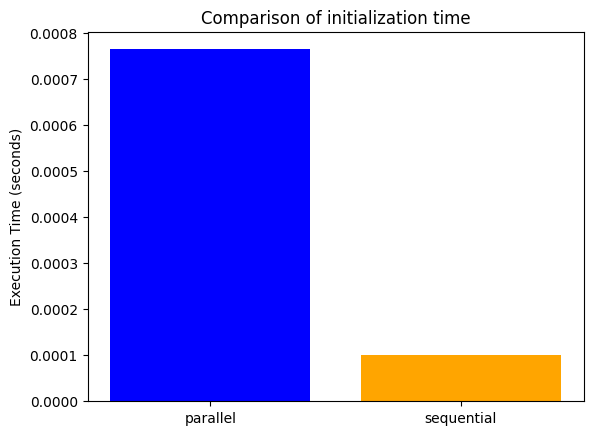

[0.00076485 0.00076848]
[0.00010088]


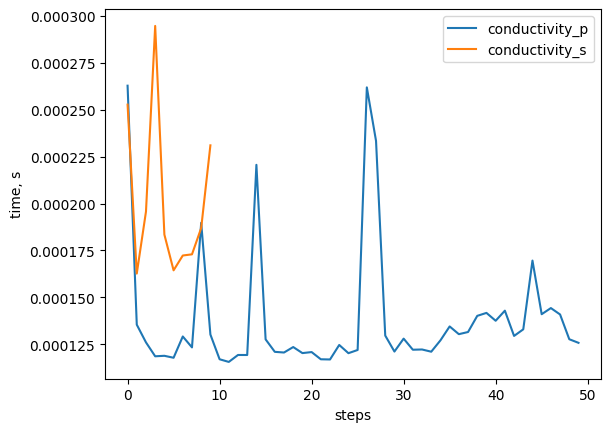

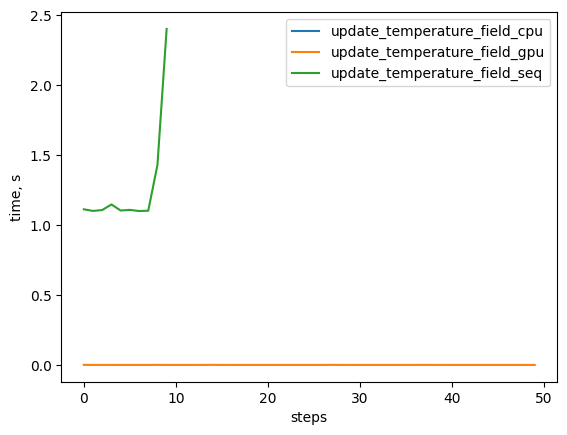

[0.16178801200021553, 12.7141167890004]


In [ ]:
print(MY_PROFILER.initialization)
MY_PROFILER.visualize()

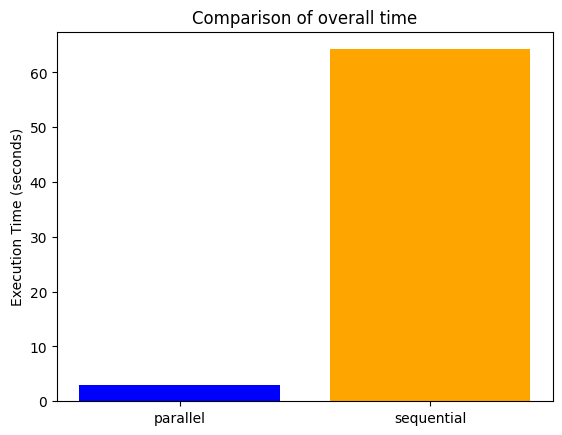

In [ ]:
plt.bar(["parallel", "sequential"], [MY_PROFILER.overall[0], MY_PROFILER.overall[1]], color=["blue", "orange"])
plt.ylabel("Execution Time (seconds)")
plt.title("Comparison of overall time")
plt.show()